In [41]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (20, 8)})

In [42]:
from models_gaussian_2d import *
from eval_utils import *
import time

In [43]:
from sklearn.decomposition import PCA
from celluloid import Camera
import matplotlib.cm as cm
from IPython.display import display, Markdown, Latex, HTML

In [44]:
import os
# os.chdir('./wodociagi')

In [45]:
import pandas as pd
import numpy as np

In [46]:
plt.rcParams.update({'figure.figsize': (20, 8)})

# Prepare Data

In [48]:
df_main = pd.read_excel('../../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
df_main = df_main.ffill()
df_main["V_delta"] = np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist())

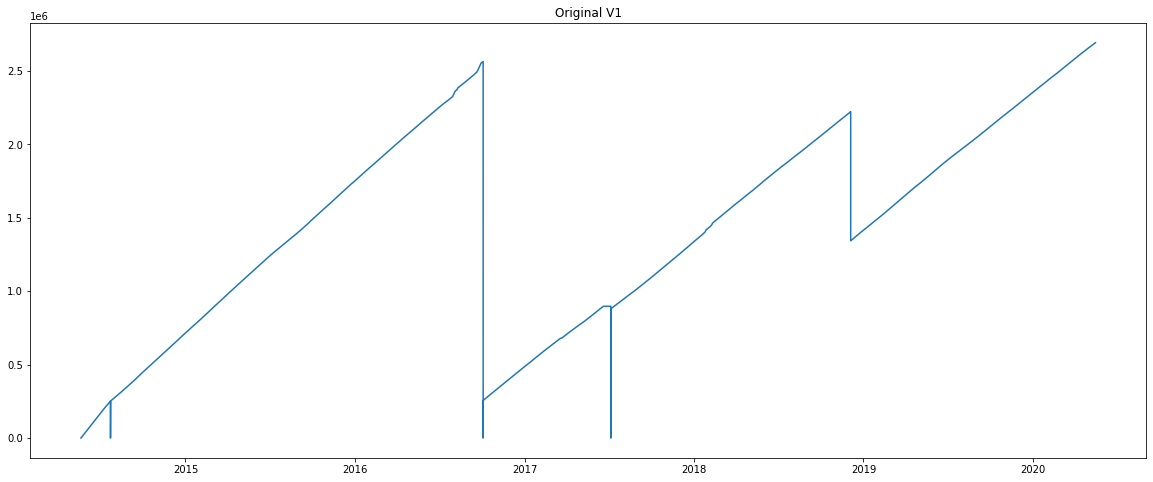

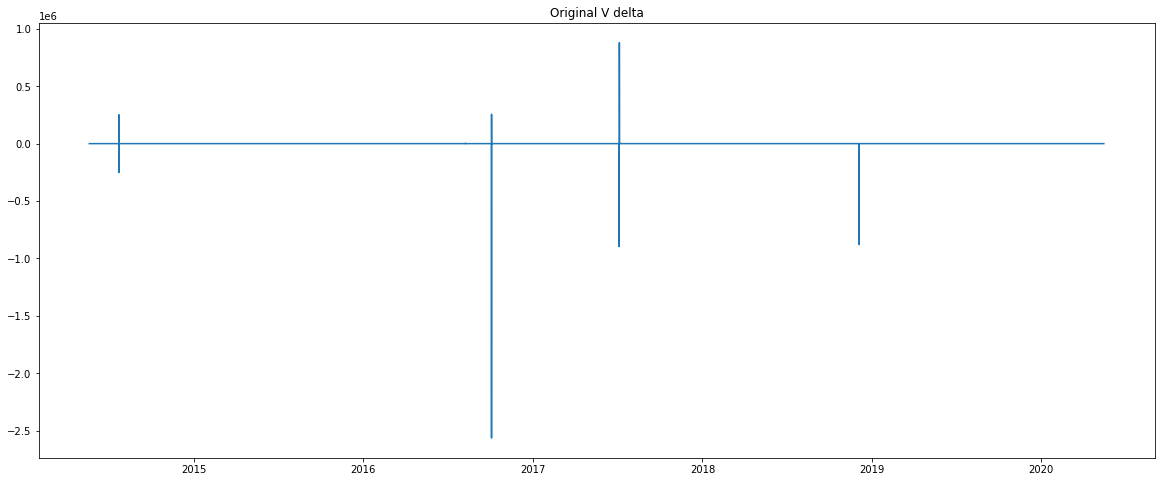

In [49]:
plt.plot(df_main["mtime"], df_main["V1"])
plt.title("Original V1")
plt.show()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("Original V delta")
plt.show()

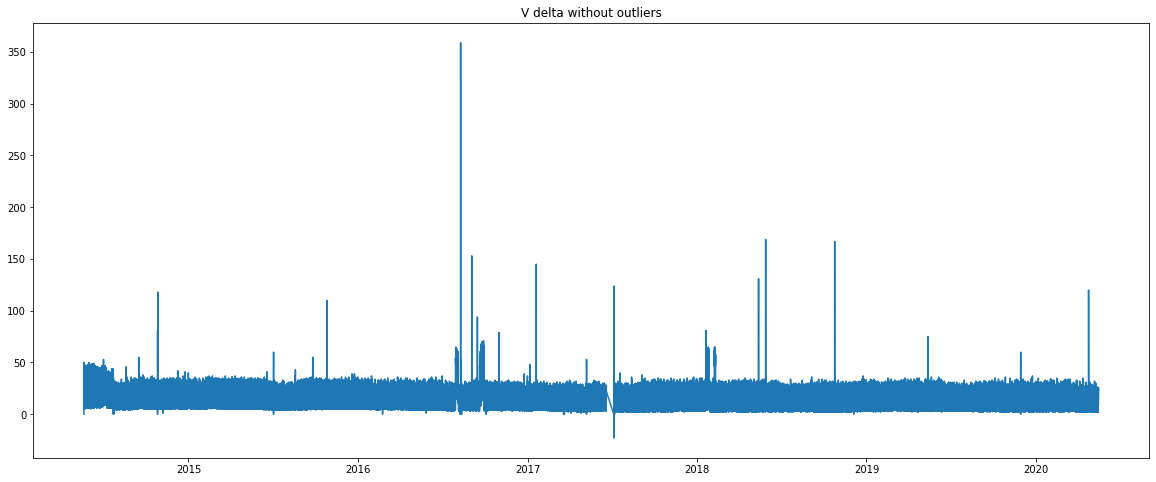

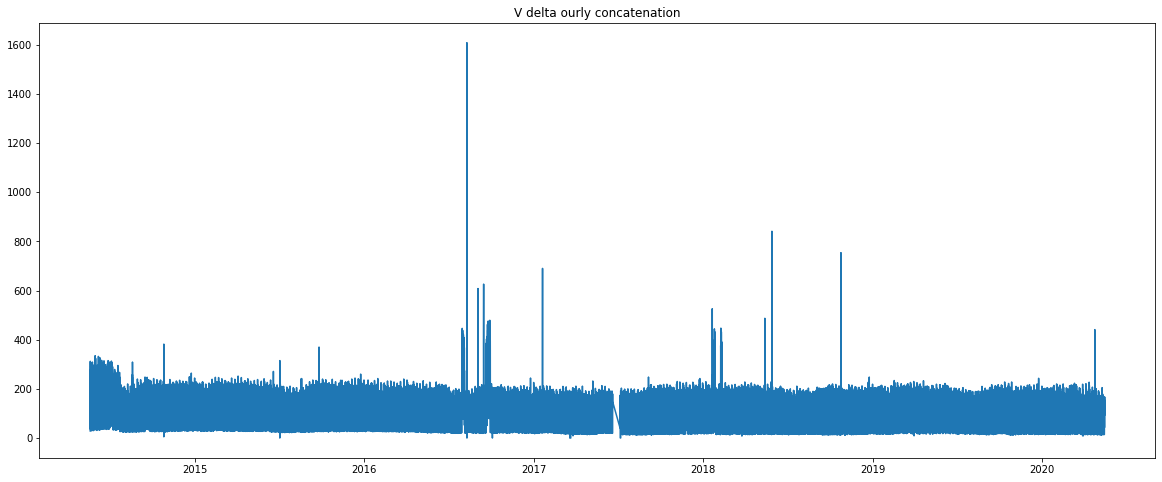

In [50]:
df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta without outliers")
plt.show()

df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta ourly concatenation")
plt.show()

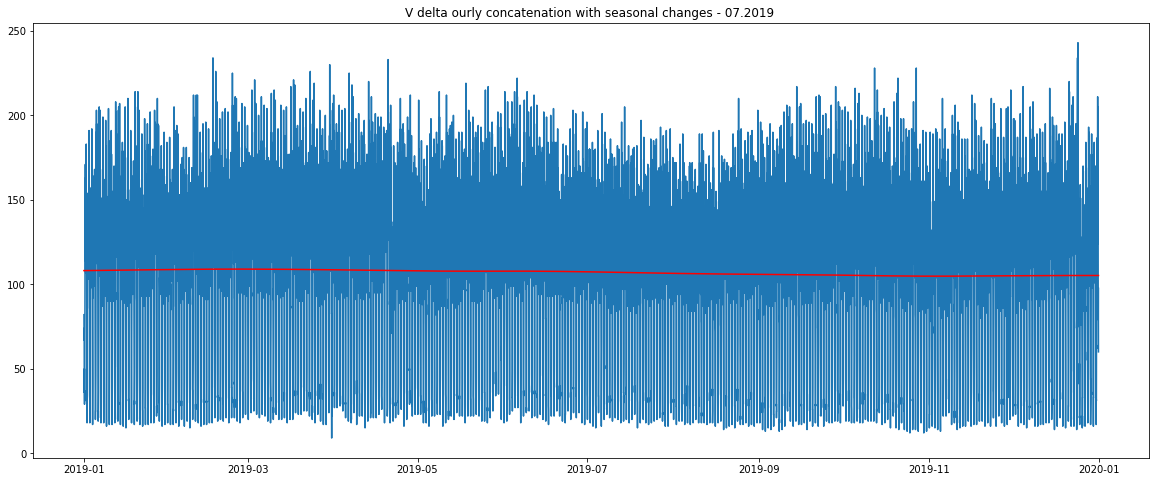

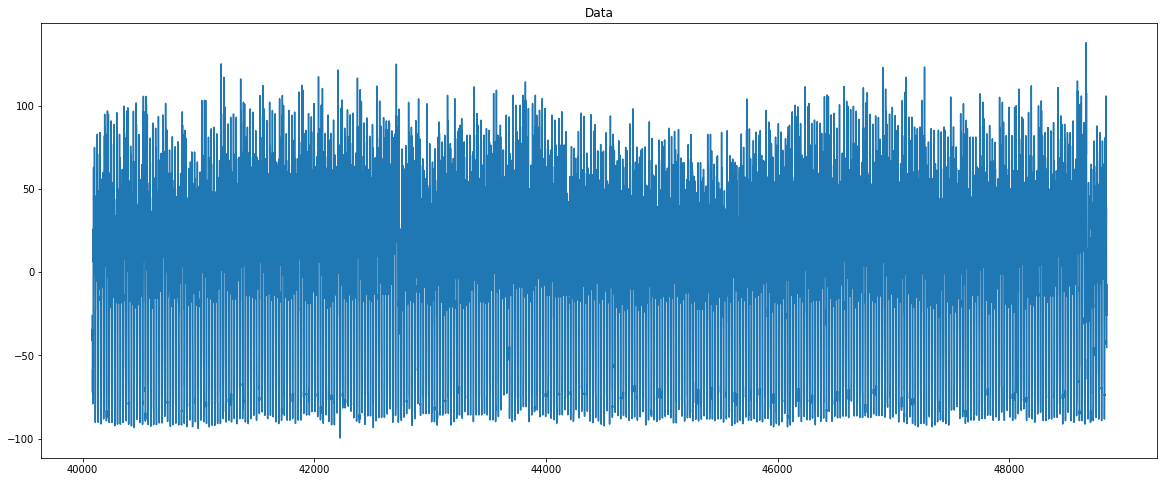

In [83]:
plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], df_main.loc[(df_main.mtime.dt.year == 2019), "V_delta"])


seasonal_changes = df_main.V_delta.rolling(24 * 42 * 6, center=True, min_periods=2).mean().rolling(24 * 7 * 6, center=True, min_periods=2).mean()[(df_main.mtime.dt.year == 2019)]

plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], seasonal_changes , color = "red")
plt.title("V delta ourly concatenation with seasonal changes - 07.2019 ")
plt.show()

data = df_main.V_delta[(df_main.mtime.dt.year == 2019)] - seasonal_changes

plt.plot(data)
plt.title("Data")

lengths = np.array([24 * 7 * 6 for _ in range(data.shape[0] // (24 * 7 * 6))] + [
    data.shape[0] - (data.shape[0] // (24 * 6 * 7)) * 24 * 7 * 6])
Y_true = data.values.reshape(-1, 1)

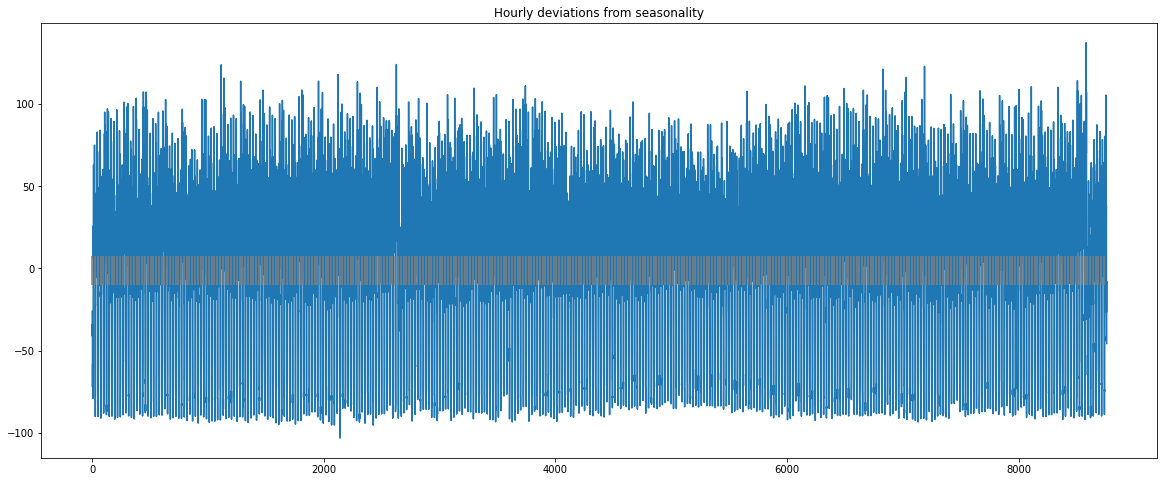

In [52]:
plt.plot(Y_true)
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -10, 7.5, color='grey')
plt.show()

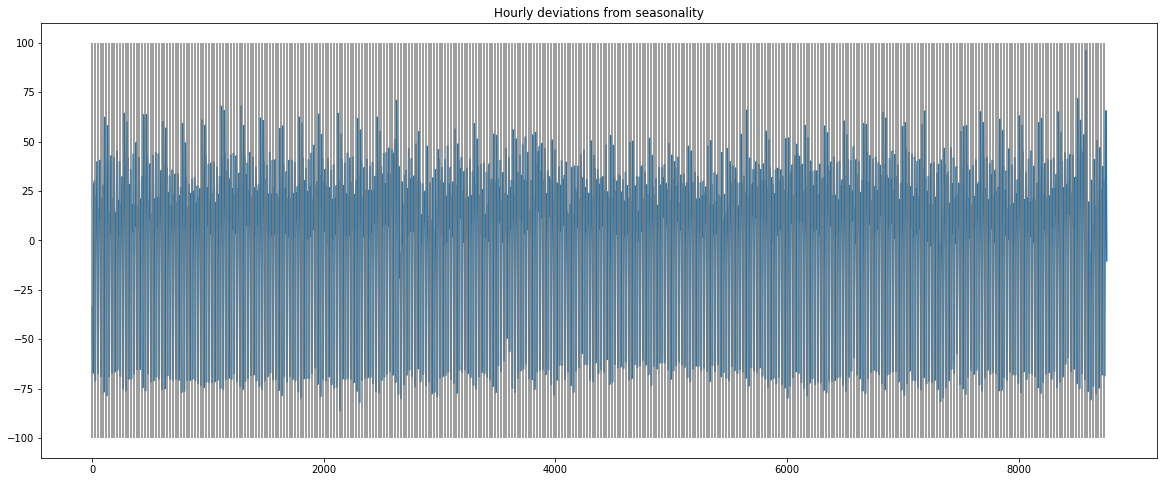

In [53]:
plt.plot(pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean())
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -100, 100, color='grey')
plt.show()

In [54]:
print(Y_true.shape)
Y_true = pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean().values.reshape(-1, 1)
print(Y_true.shape)

(8760, 1)
(8760, 1)


# Build model

In [55]:
n = 10
l = 4
lr = 0.03271365590433669
ITER = 714450


lr = 0.1
ITER = 70000

TOLERANCE = 1e-4

def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"first-runs-2",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": None,
        "lr": lr,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

In [56]:
hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                log_config={'metrics_after_convergence': True})
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)

omage_dtv,██▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
total_log_prob,▁▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
omage_dtv,0.01657
time,134.69755
total_log_prob,-93786.99681


In [57]:
start = time.perf_counter()
densehmm.fit_coocs(Y_true,lengths)
time_tmp = time.perf_counter() - start

         1     -104948.9554             +nan
         2     -103389.9166       +1559.0389
         3     -102011.0875       +1378.8290
         4     -100680.0356       +1331.0519
         5      -99905.8257        +774.2100
         6      -99286.9327        +618.8929
         7      -98648.1935        +638.7392
         8      -97980.7687        +667.4249
         9      -97324.7691        +655.9996
        10      -96745.9258        +578.8433
        11      -96293.6442        +452.2816
        12      -95915.6045        +378.0397
        13      -95550.7500        +364.8545
        14      -95184.5243        +366.2258
        15      -94811.0898        +373.4345
        16      -94425.2343        +385.8554
        17      -94020.5032        +404.7311
        18      -93588.4686        +432.0346
        19      -93120.3858        +468.0828
        20      -92612.2639        +508.1219
        21      -92075.7735        +536.4904
        22      -91555.3863        +520.3872
        23

In [58]:
# densehmm_org_aparms = densehmm
# densehmm_100k = densehmm
# densehmm_200k = densehmm
# densehmm_700k = densehmm
# densehmm_500k = densehmm

# Results

## Embeddings movement

In [59]:
z_init = np.transpose(hmm_monitor.z[-1])
pca_z = PCA(n_components=2).fit(z_init)
z = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]

z0 = list(hmm_monitor.z0)

u_init = hmm_monitor.u[-1]
pca_u = PCA(n_components=2).fit(u_init)
u = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]

In [60]:
# Draw embeddings trajectories

def draw_embeddings(embeding_list, name="?"):
    fig = plt.figure(figsize=(5, 5))
    camera = Camera(fig)
    cmap = cm.rainbow(np.linspace(0, 1, len(embeding_list[0])))
    for z_el in embeding_list:
        if z_el.shape[1] > 1:
            plt.scatter(z_el[:, 0], z_el[:, 1], color=cmap)
        else:
            plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
        camera.snap()
    plt.title(f"Embaddings trajectory:  {name}")
    animation = camera.animate().to_html5_video()
    wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation)})
    display(HTML(animation))
    plt.close()

In [61]:
draw_embeddings(z, "z")
draw_embeddings(z0, "z0")
draw_embeddings(u, "u")

## Embedding similarities

In [62]:
# Draw graph scaled with width and alpha
representation = densehmm.get_representations()

In [63]:
u_fin, z_fin, z0_fin = representation

In [64]:
u_fin

array([[-1.96850647,  0.33446858, -0.55451492, -1.13335087],
       [ 1.33999219, -0.26552381, -0.42427319,  0.46872003],
       [ 1.42828829,  1.4136096 ,  1.31671743, -1.35889624],
       [ 0.675176  ,  0.07701809,  0.3643819 ,  0.78042812],
       [-1.58892359, -0.08527056, -0.88227523,  0.04903058],
       [ 0.58941115, -1.56997574, -0.27135113, -0.25595453],
       [-0.4202054 , -0.64229658,  2.41467948, -2.21336451],
       [ 0.50388925, -1.68630874,  1.37606289,  0.75994501],
       [ 0.29179065, -0.09852691,  0.51104263,  0.33474133],
       [-0.25691473,  0.81570152, -0.73936156, -1.4685704 ]])

In [65]:
z_fin

array([[-0.5686306 ,  0.15677119,  0.85950387,  0.90281697, -1.50107354,
         1.85352455, -0.82503466, -0.82349945,  0.86587633, -0.35873337],
       [ 0.74075807, -0.51714314,  0.82585062,  0.56931466, -0.51208926,
        -1.6979    ,  0.82640721, -0.08073068, -1.77117139,  1.4060221 ],
       [-1.12038392, -0.03462602, -0.53370491, -1.07589645,  0.04206087,
        -2.46805671,  1.46472771,  0.28960648,  0.48443297, -0.49633976],
       [-0.16958297,  0.3978022 , -1.59718399,  0.8202197 ,  0.88103289,
        -0.15631991,  0.07994953,  1.19096424,  0.55740964, -0.83908248]])

In [66]:
z0_fin

array([[-0.5177008 ],
       [-1.54942254],
       [-0.56686621],
       [-0.12536467]])

In [67]:
np.matmul(u_fin, z_fin)

array([[ 2.18057992, -0.91322206,  0.69039936, -1.91977926,  1.76175242,
        -2.67082968,  0.99766906,  0.08369065, -3.19725034,  2.40264184],
       [-0.56278754,  0.54853473,  0.41025003,  1.89952851, -1.48034246,
         3.90840132, -1.90894154, -0.6466904 ,  1.68629283, -1.03674337],
       [-1.00980908, -1.09328864,  3.86271843, -0.4369735 , -4.00971006,
        -2.79011109,  1.80981922, -2.52738322, -1.38662439,  1.96187848],
       [-0.8674689 ,  0.3638577 , -0.79703788,  0.90149321, -0.35001991,
         0.09937465,  0.10271983,  0.47276455,  1.05974345, -0.96961982],
       [ 1.82051795, -0.1549462 , -1.04354295, -0.49360032,  2.43484559,
        -0.63048713, -0.0479242 ,  1.1182427 , -1.62485564,  0.8468752 ],
       [-1.15070645,  0.8118814 , -0.23633637, -0.27967304, -0.31769939,
         4.4678706 , -2.20164286, -0.74205228,  3.01693032, -2.06941272],
       [-2.56686387, -0.69780884,  1.35481486, -5.15842769, -0.88881104,
        -5.30187863,  3.17577599, -1.53883919

In [68]:
z0_fin_red = z0[-1]
z_fin_red = z[-1]
u_fin_red = u[-1]

In [69]:
A_trained = np.exp(np.matmul(u_fin, z_fin)) / np.exp(np.matmul(u_fin, z_fin)).sum(axis=1).reshape(-1, 1)

In [70]:
A_largest = A_trained * (A_trained == A_trained.max(axis=1).reshape(-1, 1))

In [71]:
A_largest

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.34347385],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.74398028, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.76064513, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.22975791, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.4310037 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.7703718 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.74884292, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [72]:
import itertools

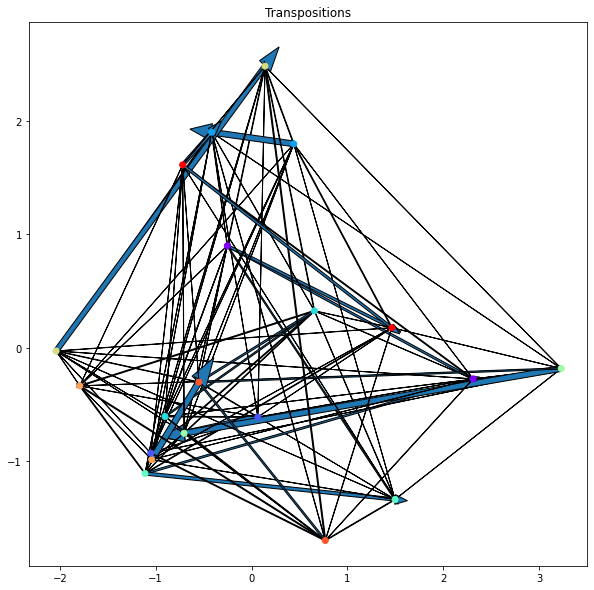

In [73]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    plt.arrow(z_fin_red[i, 0], z_fin_red[i, 1], u_fin_red[j, 0] - z_fin_red[i, 0], u_fin_red[j, 1] - z_fin_red[i, 1], width=A_trained[i, j]/15)

plt.scatter(z_fin_red[:, 0], z_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(u_fin_red[:, 0], u_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

In [74]:
z_fin_red

array([[-0.25269194,  0.8976782 ],
       [ 0.06559998, -0.61343301],
       [ 0.4406215 ,  1.7971441 ],
       [ 0.65596979,  0.32367858],
       [-1.11112559, -1.11099696],
       [ 3.23017334, -0.18457119],
       [-2.0381572 , -0.03045959],
       [-1.04157647, -0.98858625],
       [ 0.76929942, -1.70234743],
       [-0.71811282,  1.61189353]])

In [75]:
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [76]:
pca_uz = PCA(n_components=2)
uz_fin_red = pca_uz.fit_transform(uz_fin)

In [77]:
uz_fin_red

array([[-1.46294216, -0.02133822],
       [ 1.23043524, -0.08453758],
       [-1.0595701 ,  2.74519683],
       [ 1.07871222,  0.45068951],
       [-0.45900019, -1.99970649],
       [ 2.90643033,  1.19327505],
       [-2.57194411, -0.91487129],
       [ 0.68054608, -1.96523519],
       [ 1.43782849, -0.5730066 ],
       [-1.78049581,  1.16953397]])

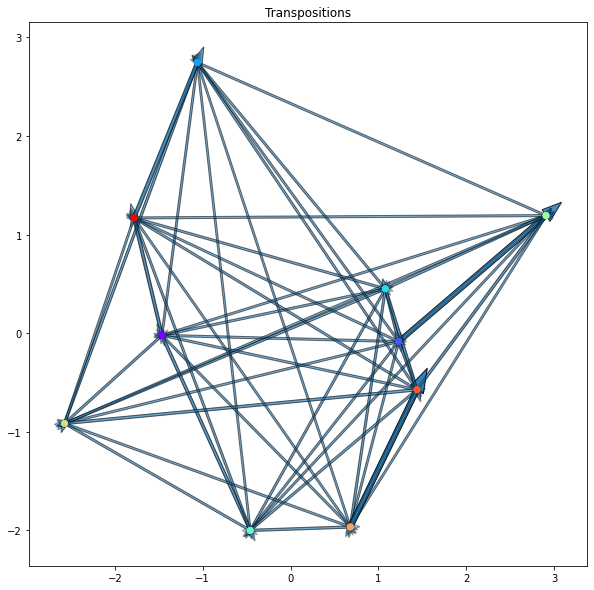

In [78]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    if i == j:
        continue
    plt.arrow(uz_fin_red[i, 0], uz_fin_red[i, 1], uz_fin_red[j, 0] - uz_fin_red[i, 0], uz_fin_red[j, 1] - uz_fin_red[i, 1], width=(A_trained[i, j] / 1.5 + 0.33) * 0.06, alpha=A_trained[i, j] / 1.5 + 0.33)  #, color=cm.rainbow(A_trained[i, j] )

plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

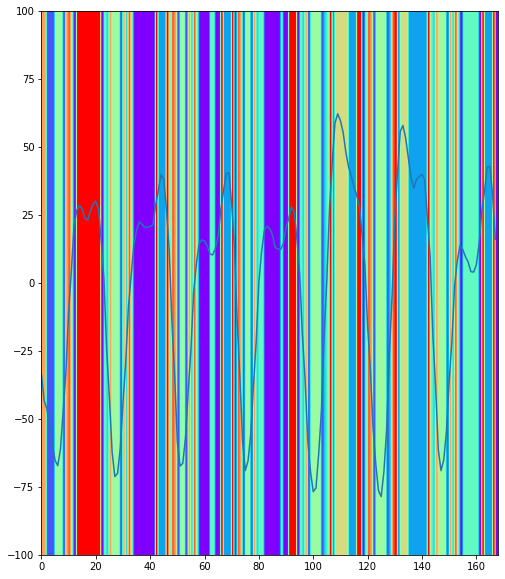

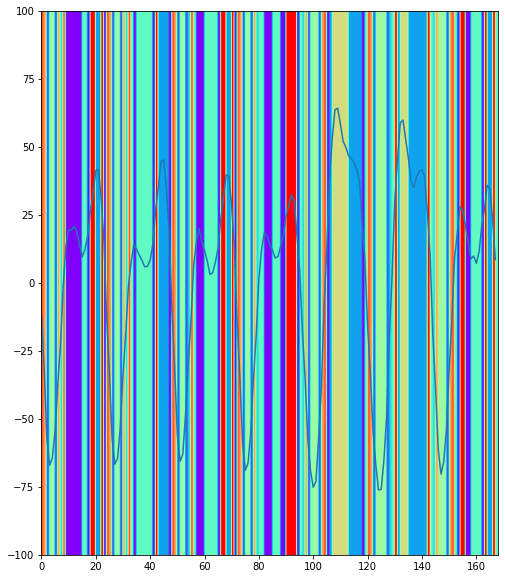

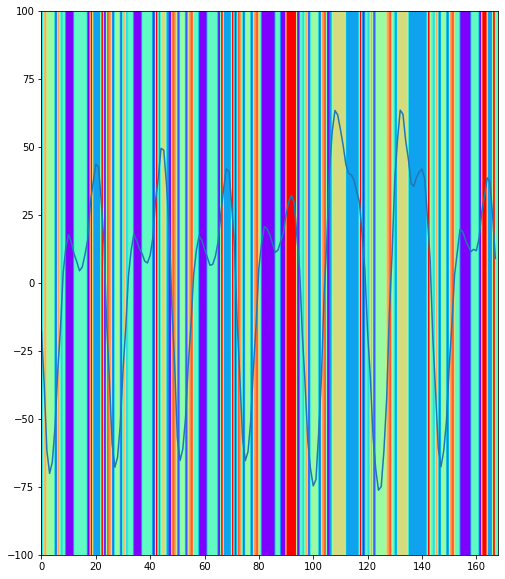

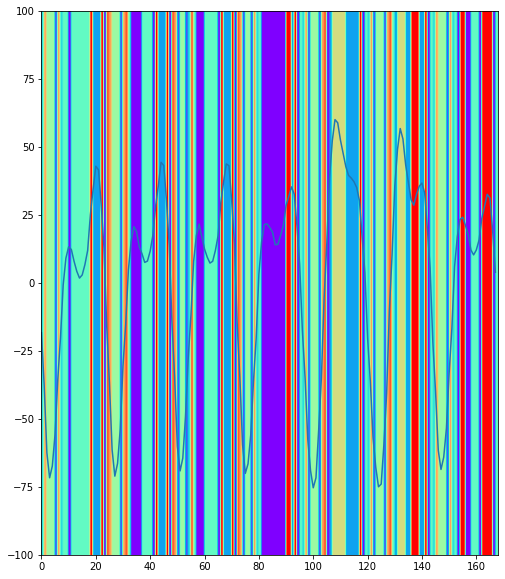

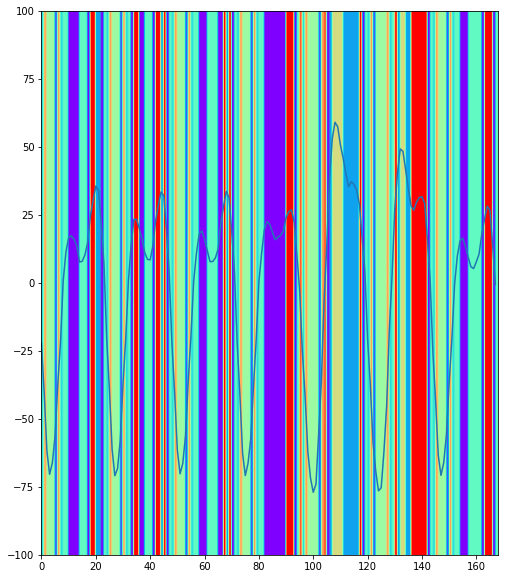

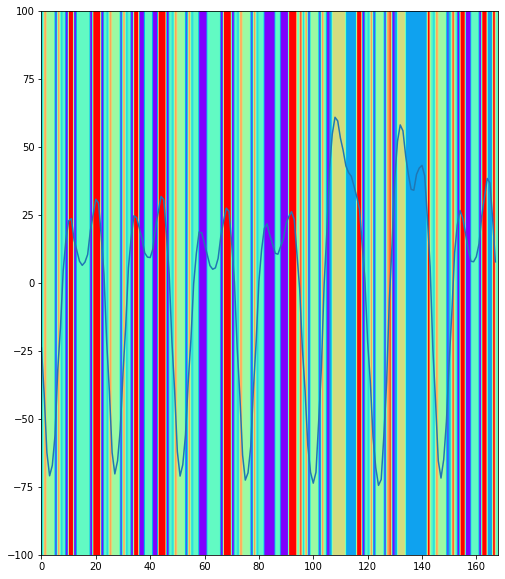

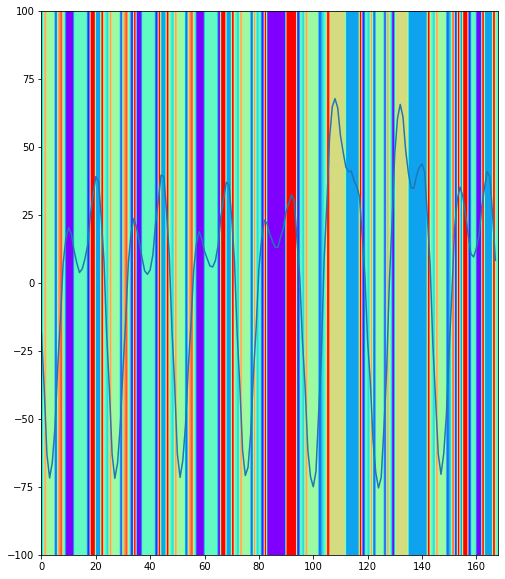

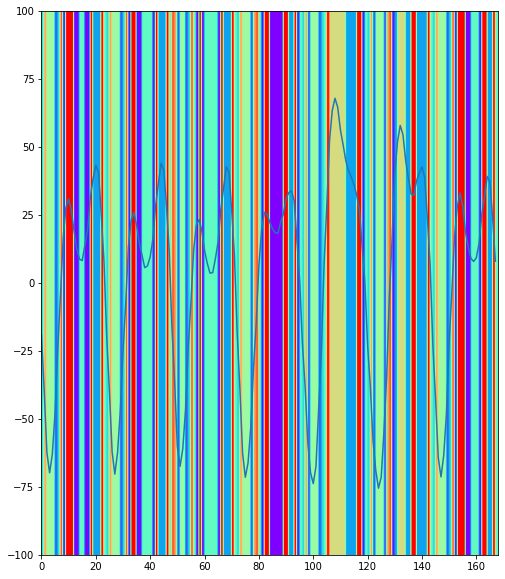

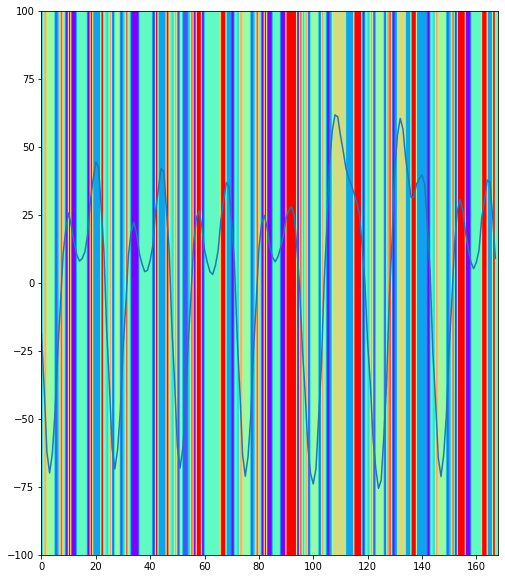

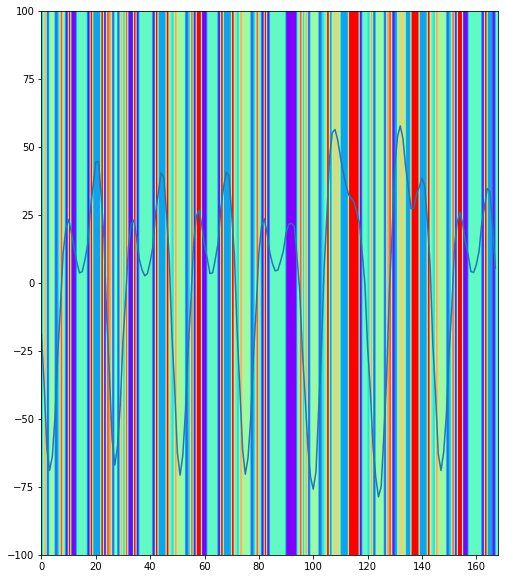

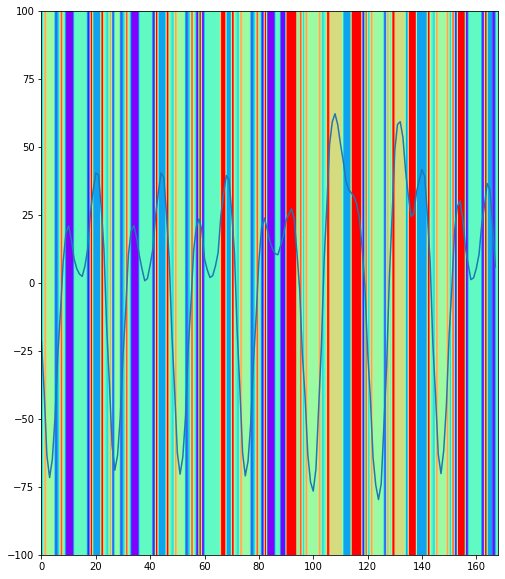

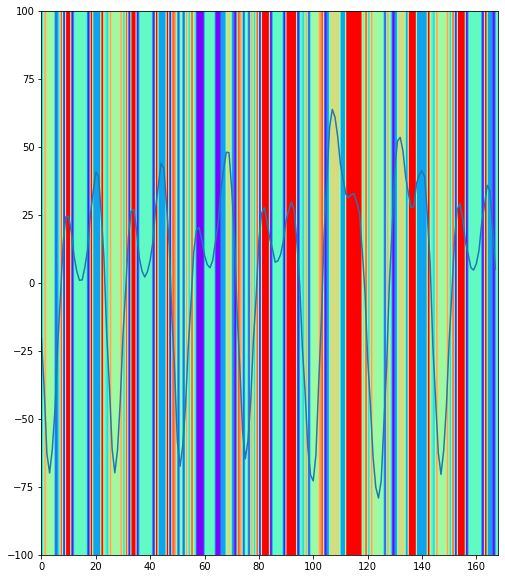

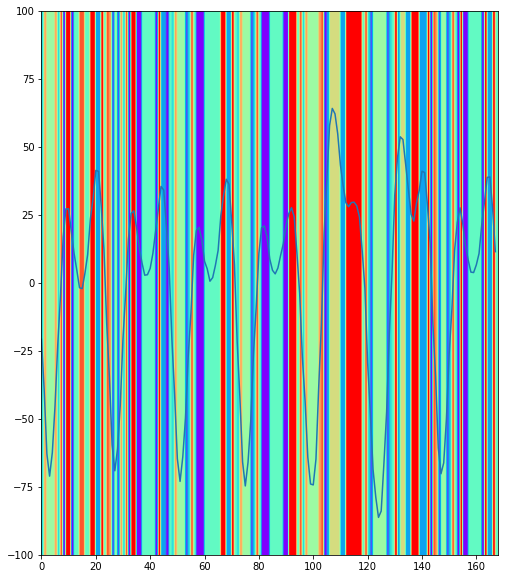

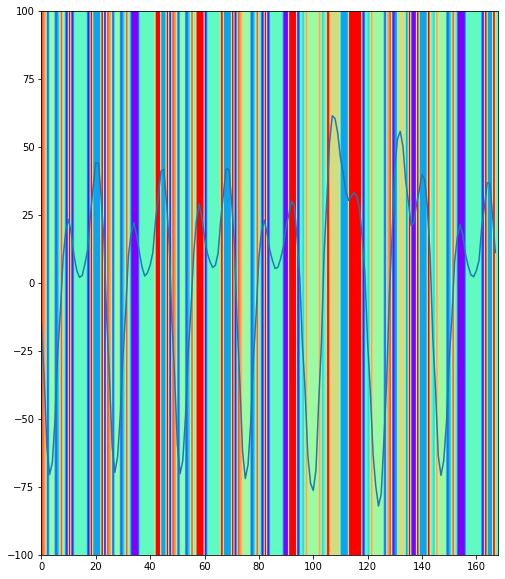

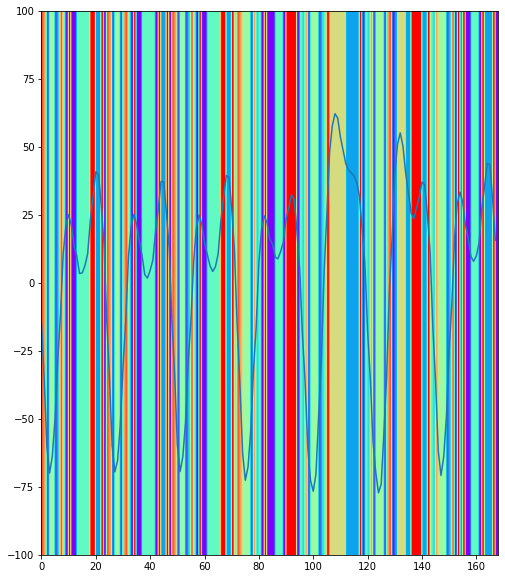

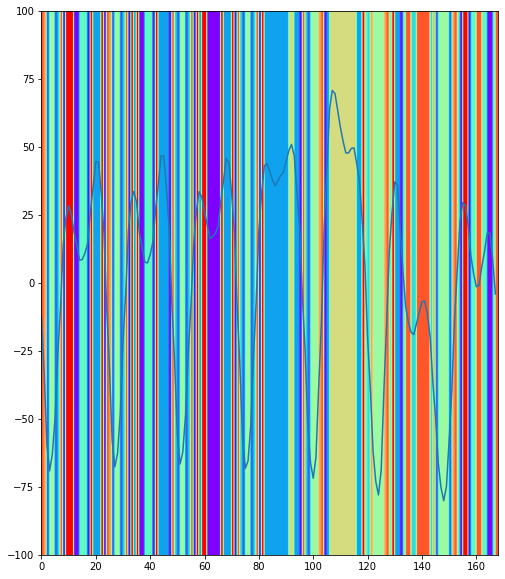

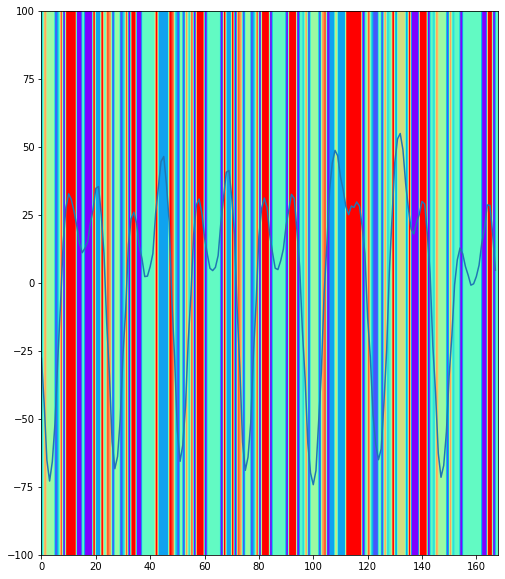

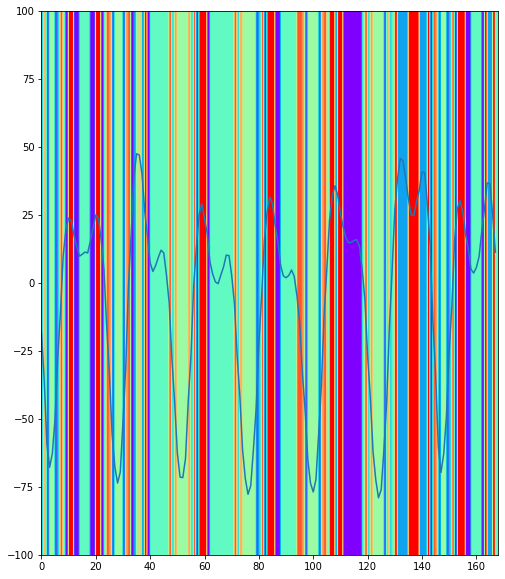

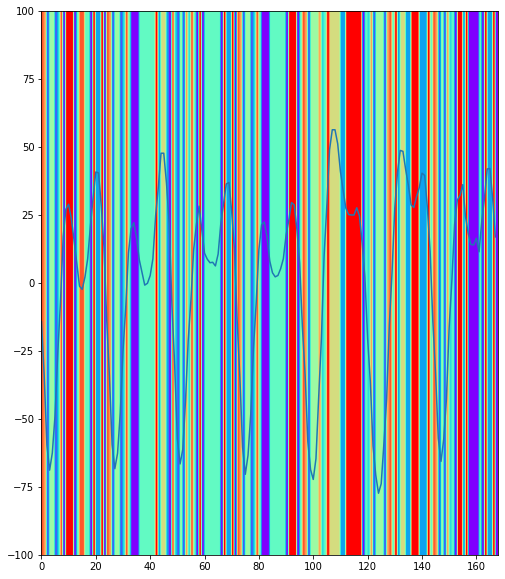

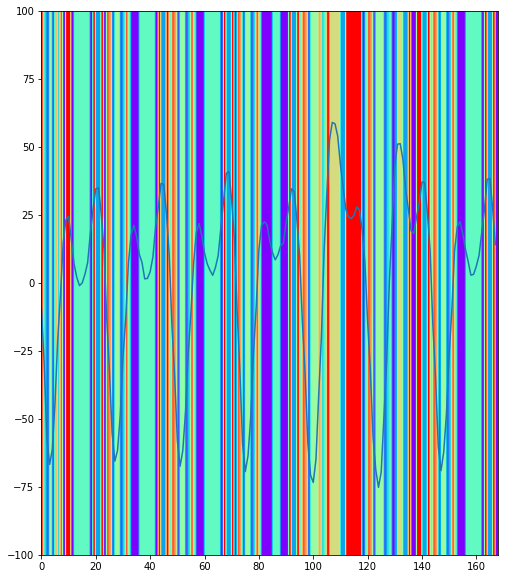

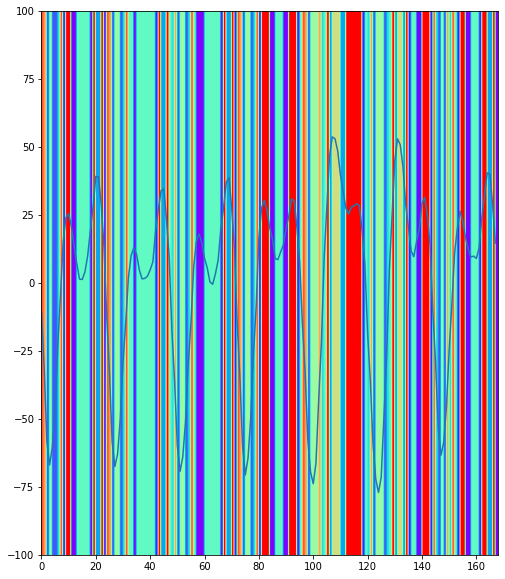

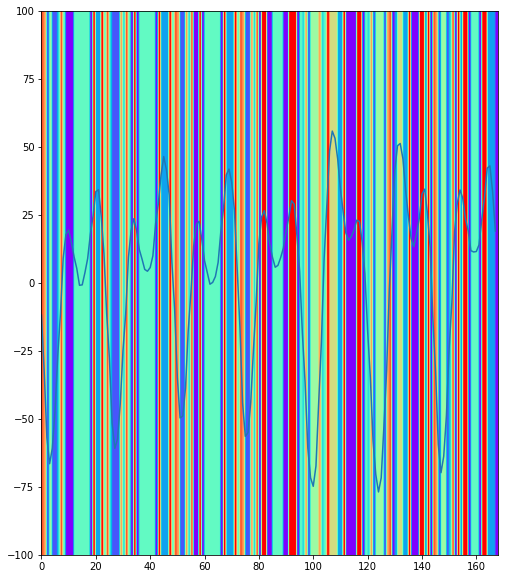

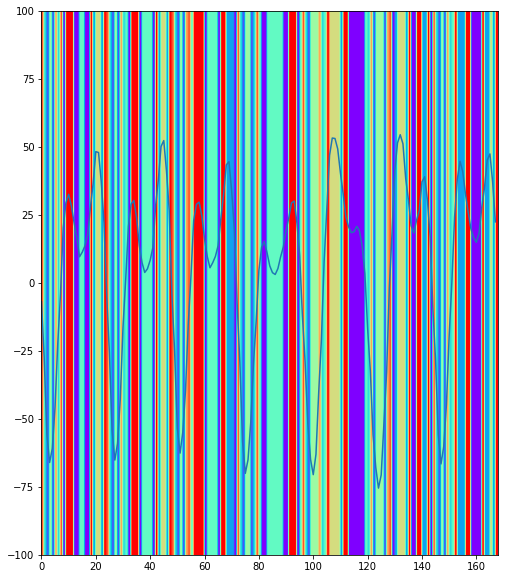

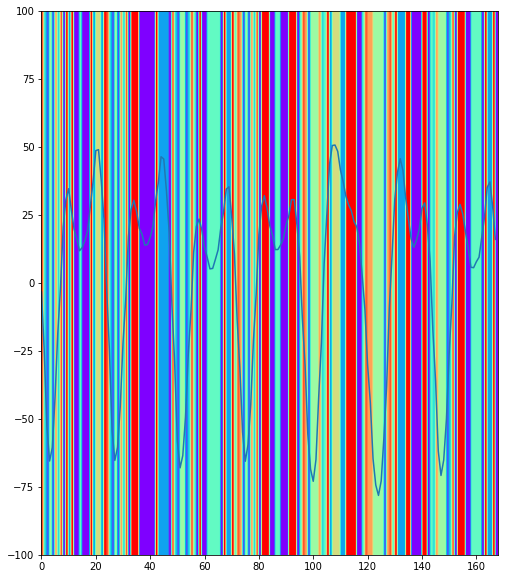

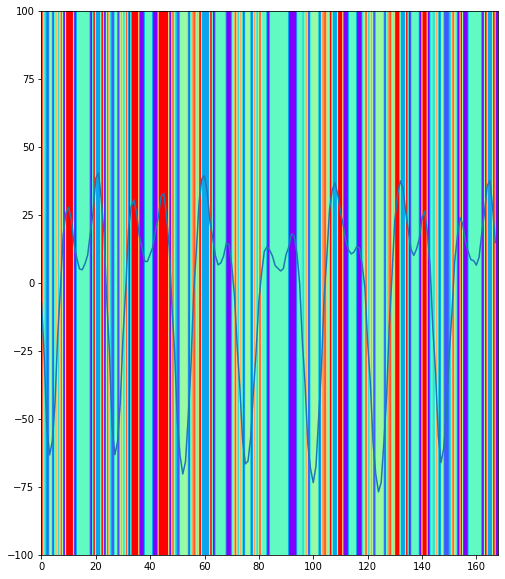

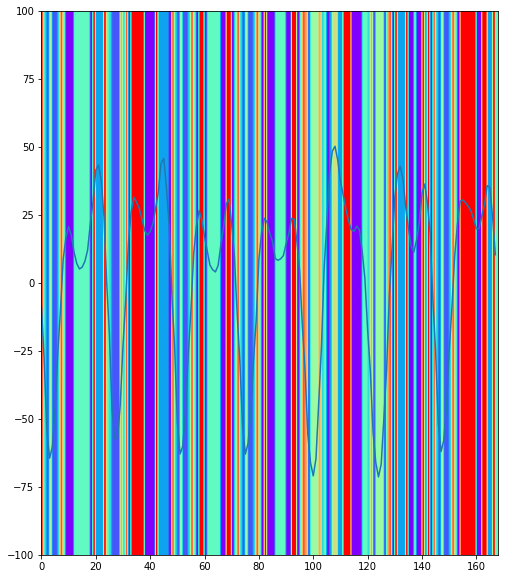

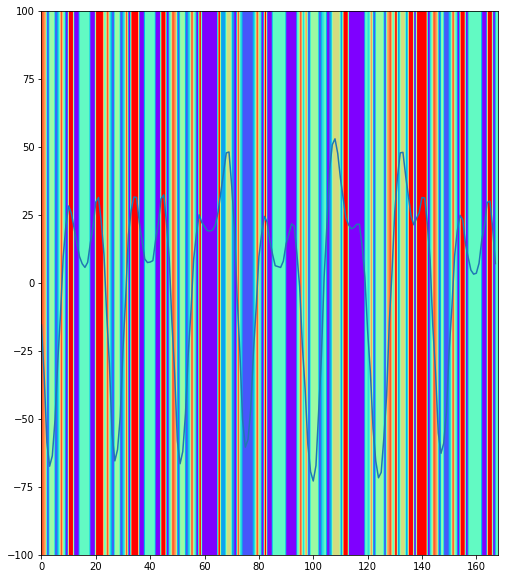

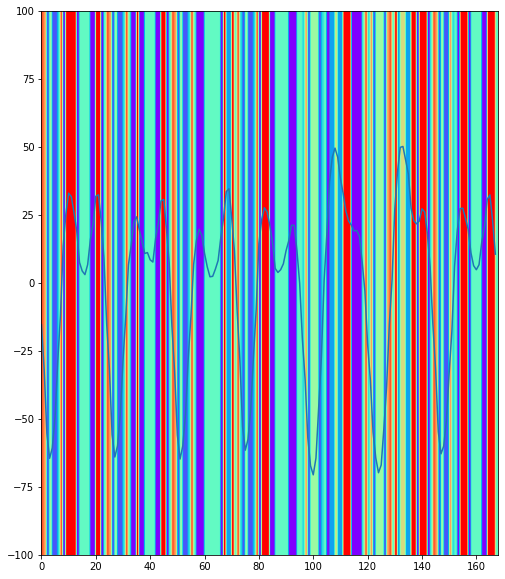

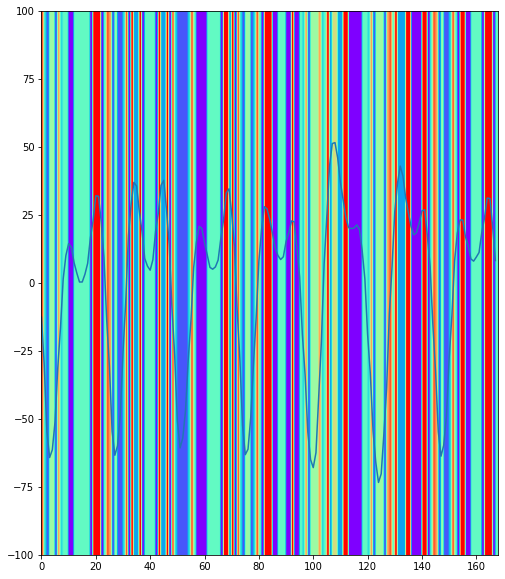

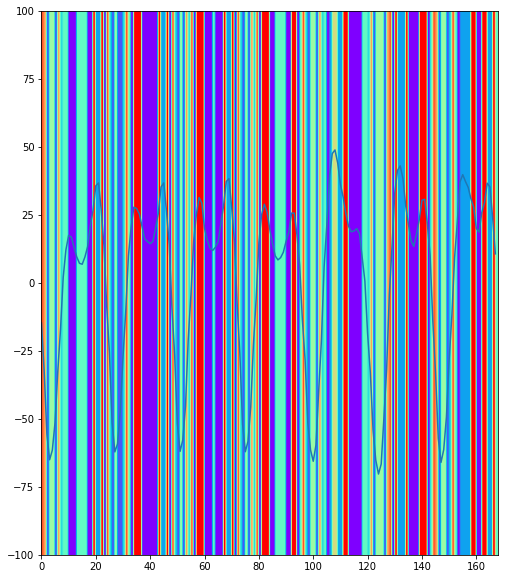

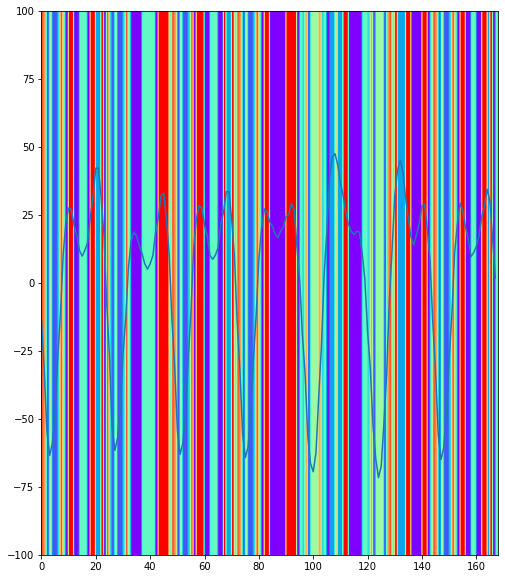

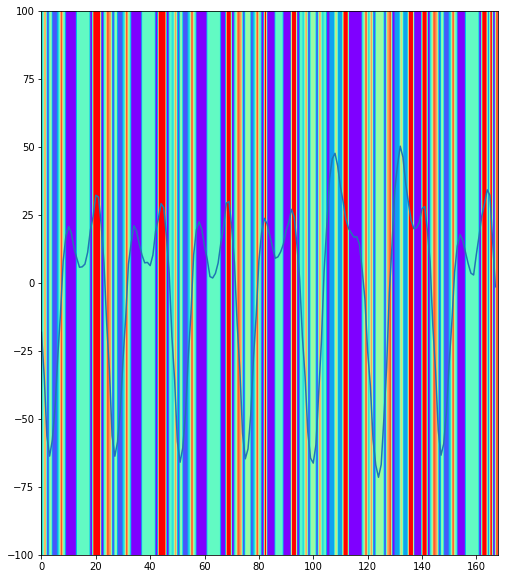

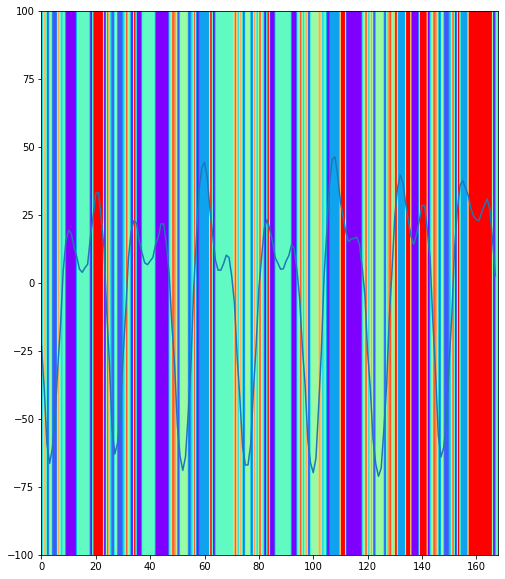

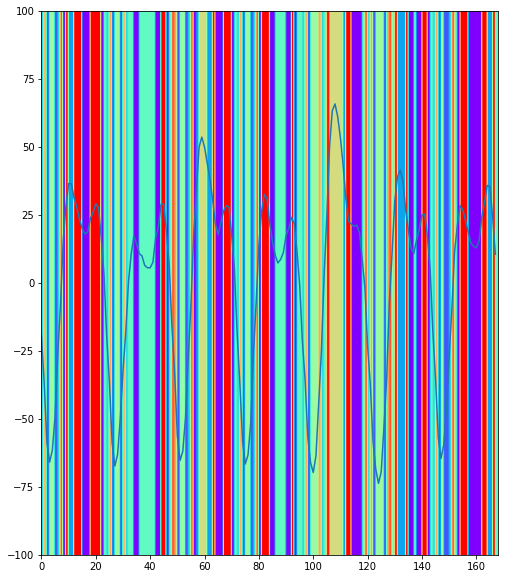

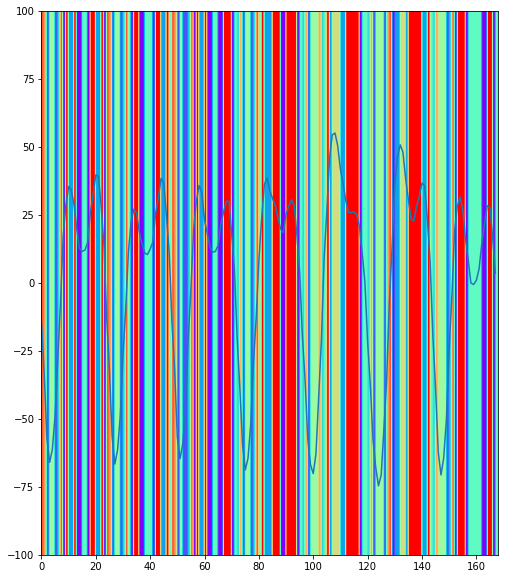

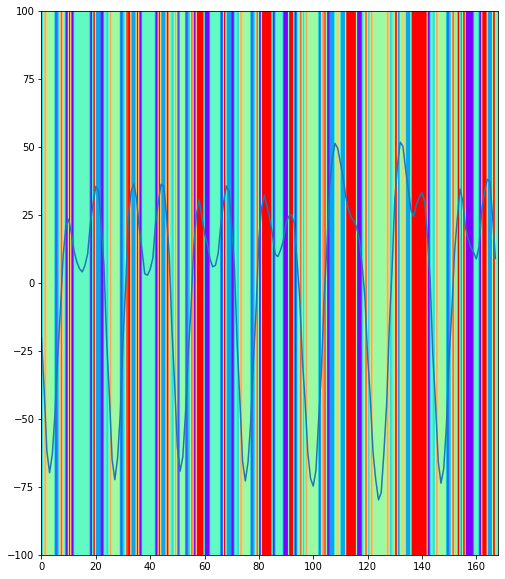

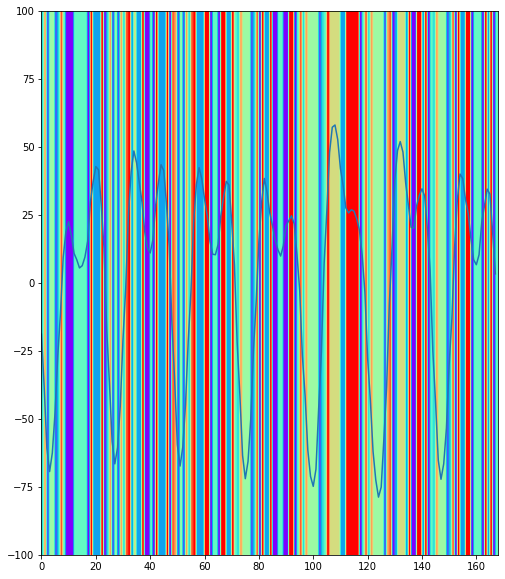

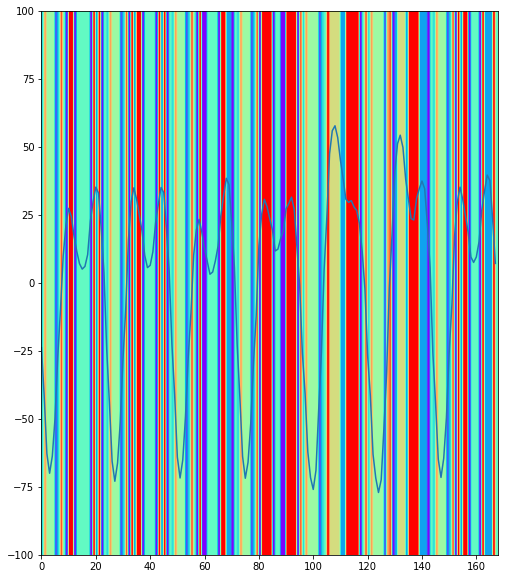

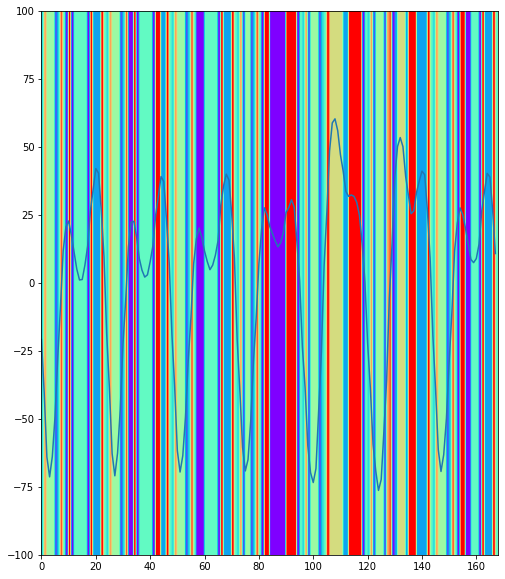

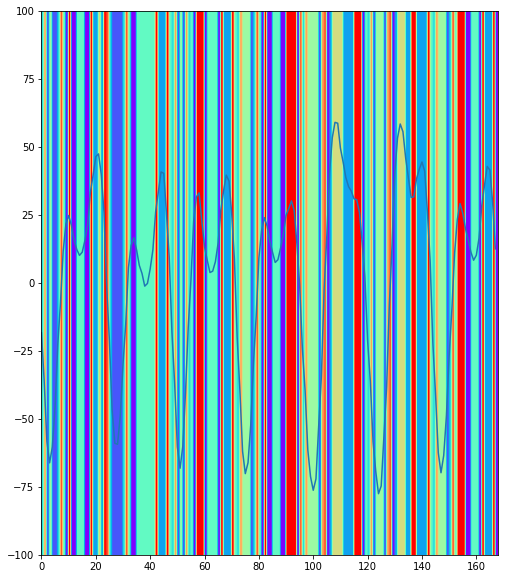

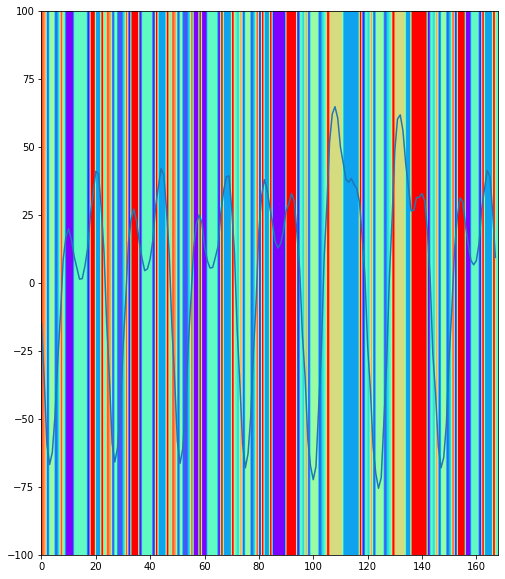

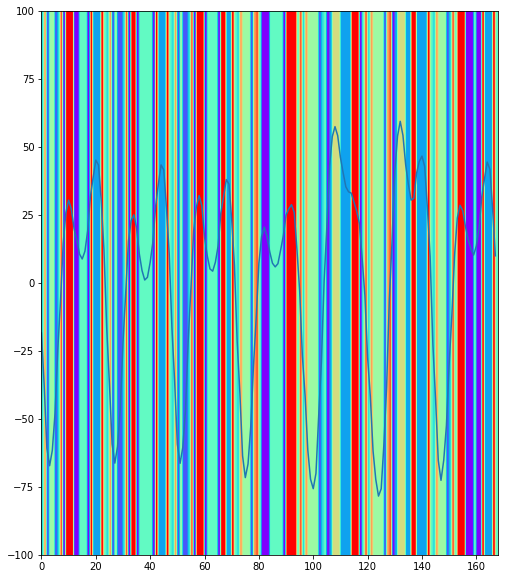

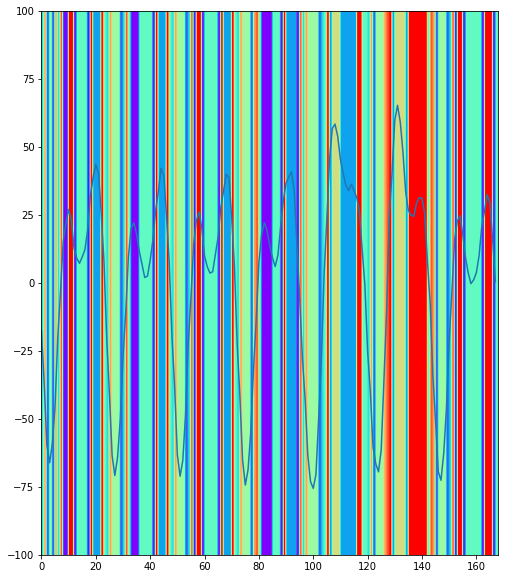

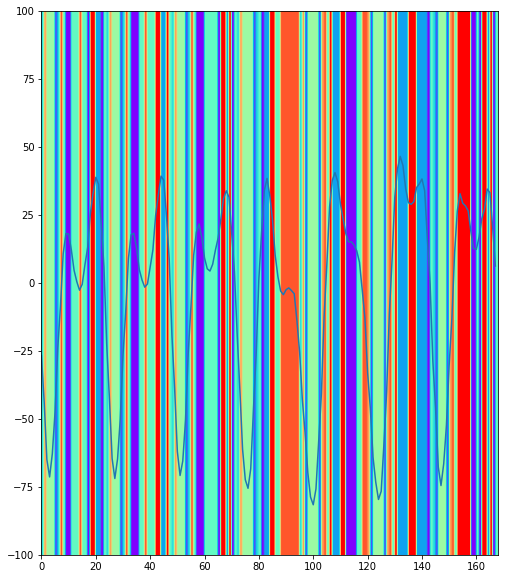

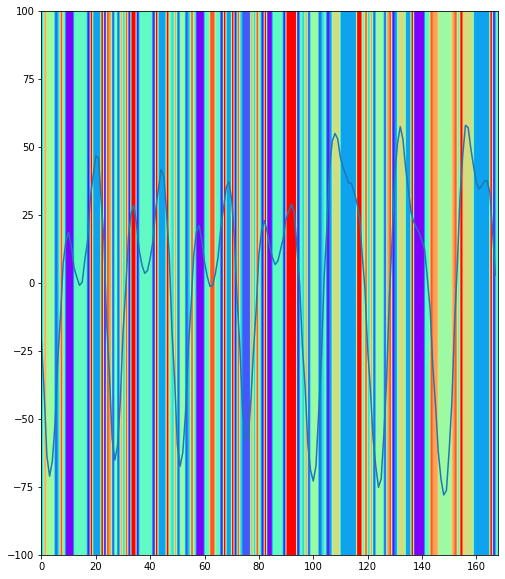

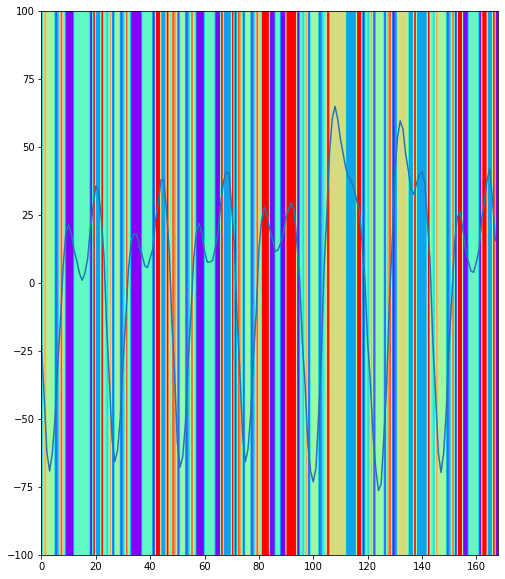

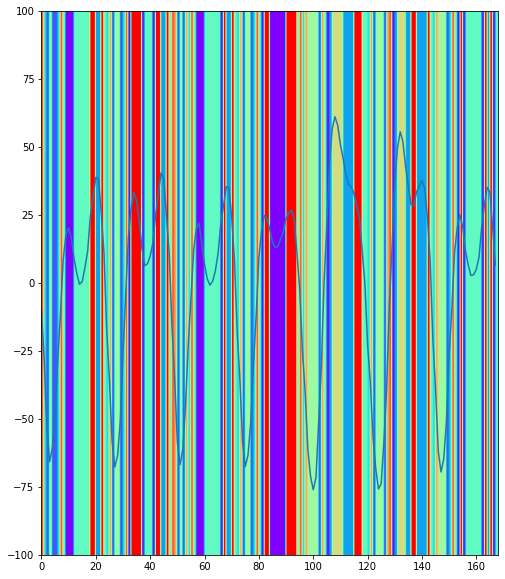

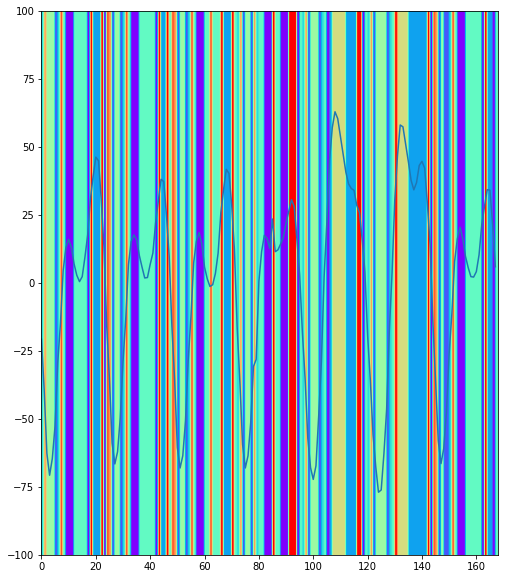

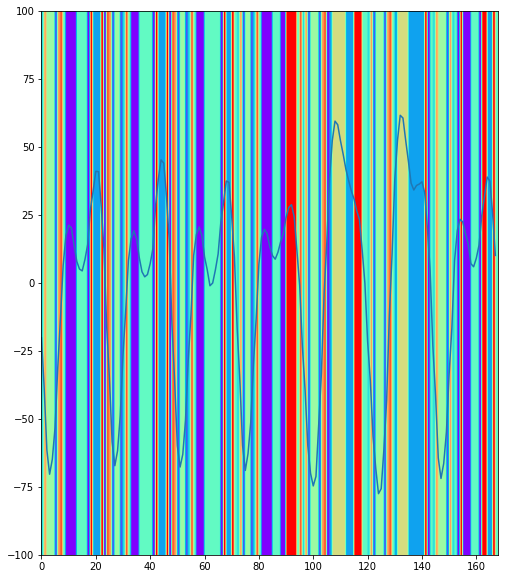

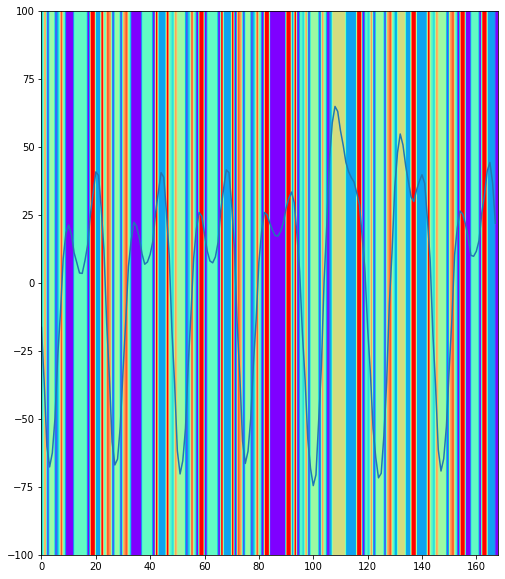

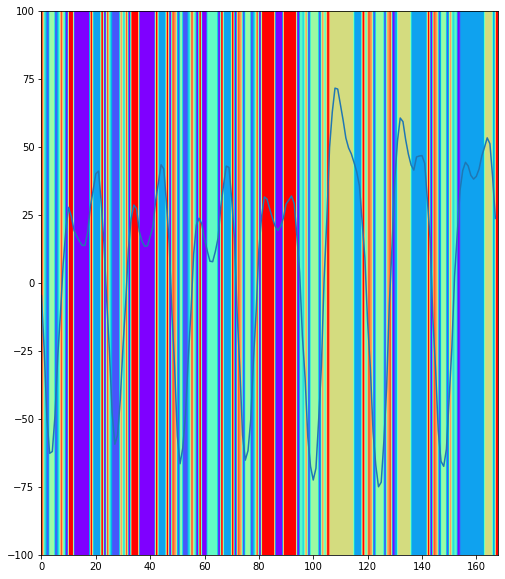

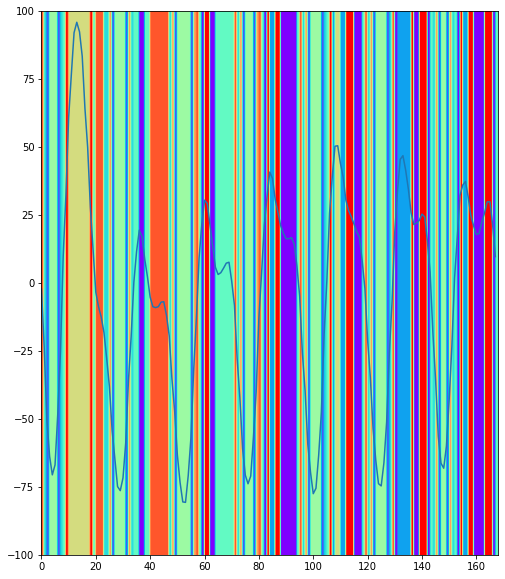

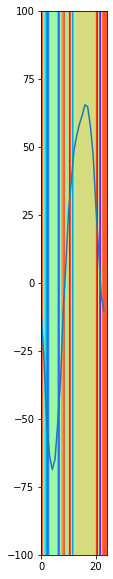

In [79]:
states = densehmm.predict(Y_true).reshape(1, -1)

interval = 7 * 24

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(10, 10))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -100, 100), cmap=cm.rainbow)
    plt.show()

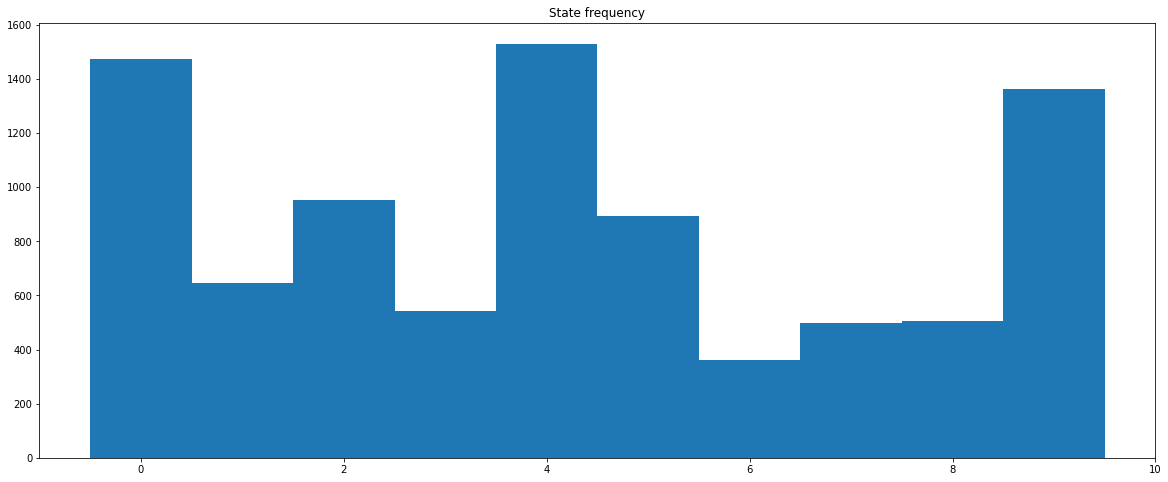

In [80]:
plt.hist(densehmm.predict(Y_true).reshape(-1), [i - 0.5 for i in range(n+1)])
plt.title("State frequency")
plt.show()

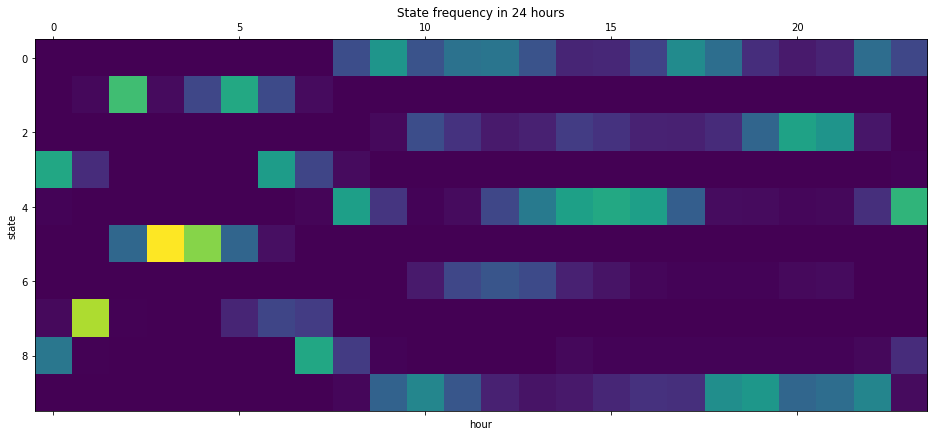

In [81]:
plt.matshow(pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % 24 }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

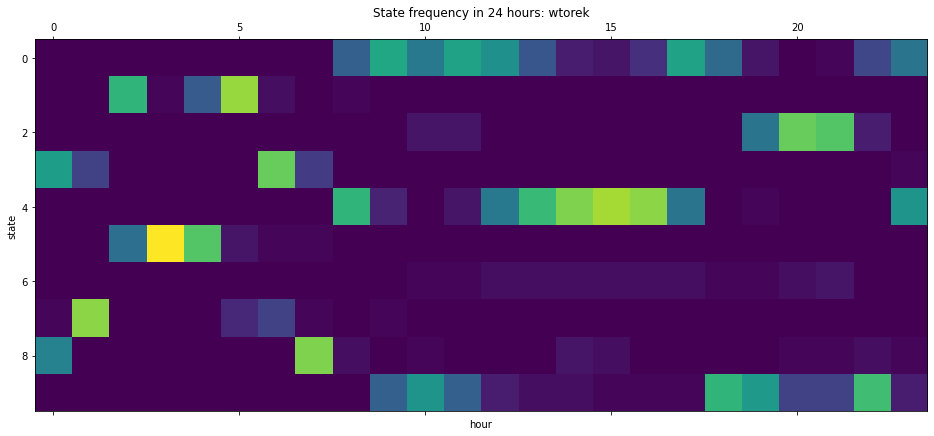

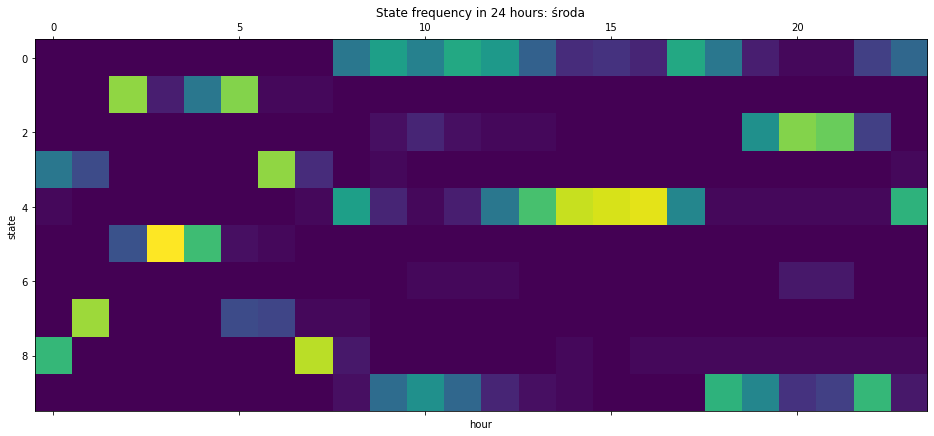

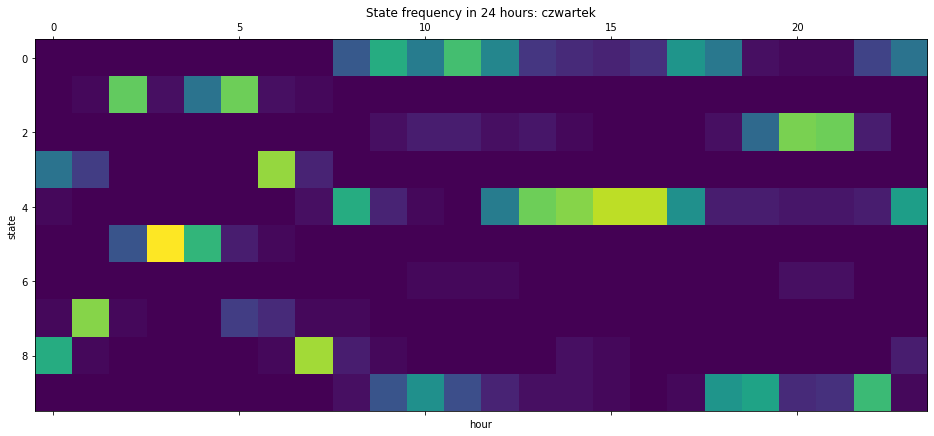

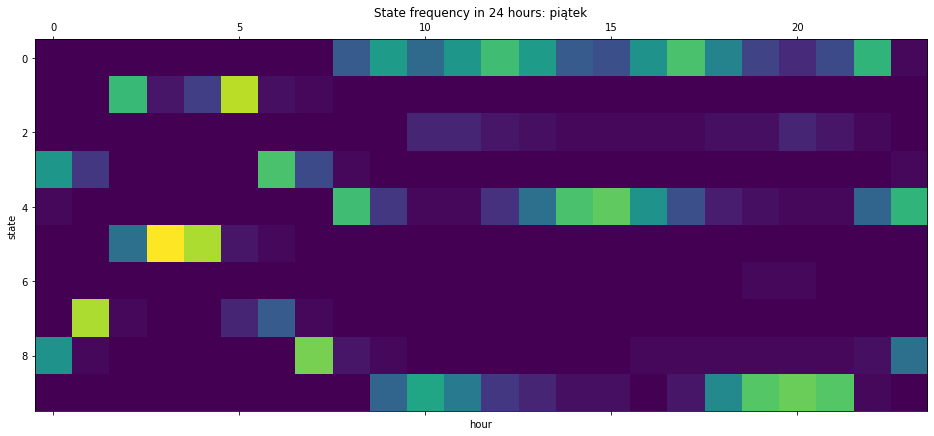

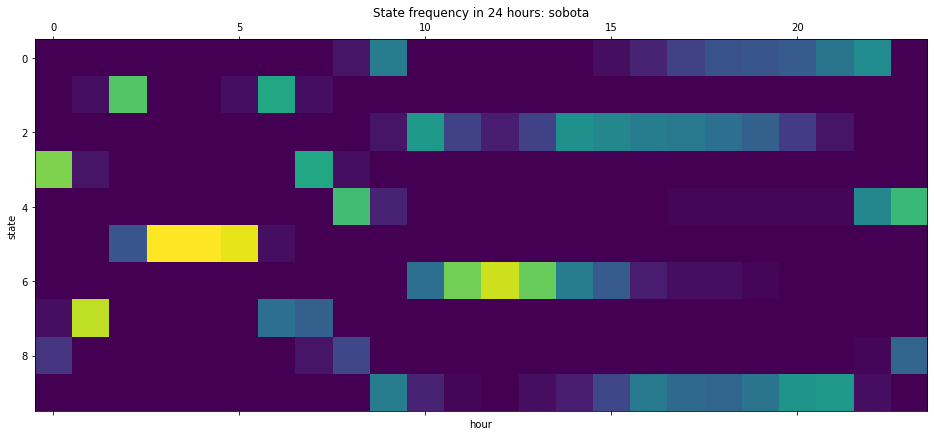

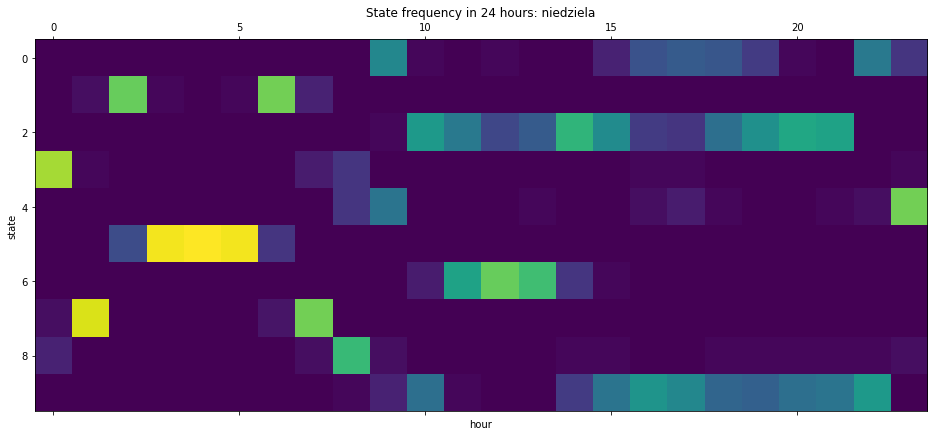

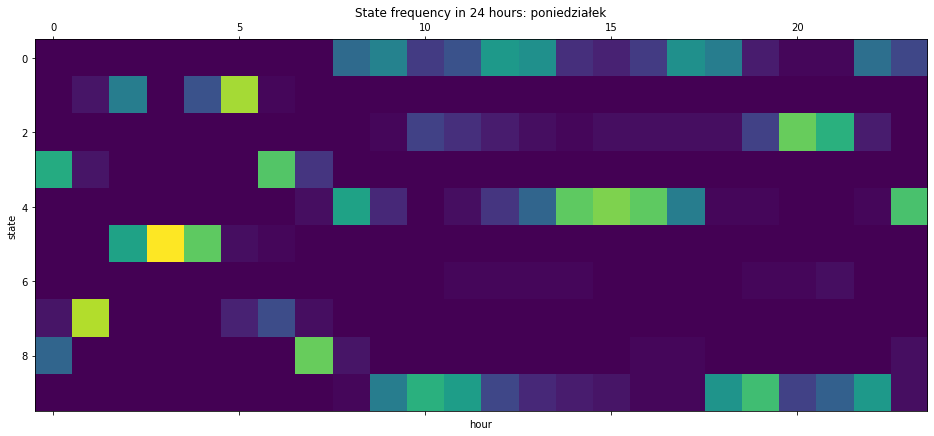

In [82]:
weekly = pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 7) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
l = weekly.shape[1] // 7
days = ['wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela', 'poniedziałek']
for i in range(7):
    plt.matshow(weekly[:, (l*i) : (l*(i+1))])
    plt.ylabel("state")
    plt.xlabel("hour")
    plt.title(f"State frequency in 24 hours: {days[i]}")
    plt.show()